### Import relevant libraries

In [23]:
import os
import ast
import pandas as pd
import numpy as np
import dask
from dask.distributed import Client

from nilearn import image
from nilearn import input_data
from nilearn import signal
from nilearn import connectome

from bids import BIDSLayout
from load_confounds import Params9
from load_confounds import AnatCompCor

import process_bids as pb
import process_connectome as pc

pd.options.mode.chained_assignment = None

### Useful Functions

In [32]:
def calculate_timeseries(atlas_masker, run_by_task_sub, subjects_im_path, csv_path, time_series_df,
                         subject_confounds_list = None, confounds_name = None):

    for i, image_path in enumerate(subjects_im_path):
        image_caract = pb.get_entities(image_path, run_by_task_sub)
        image_koi = pb.get_keys_of_interest(image_caract)

        im = image.load_img(image_path)
        time_series = atlas_masker.fit_transform(im, confounds=None)
        time_series_df.loc['None',image_koi] = time_series.tolist()

        for j, confounds in enumerate(subject_confounds_list):
            time_series_cleaned = signal.clean(time_series, confounds=confounds[i])
            time_series_df.loc[confounds_name[j+1], image_koi] = time_series_cleaned.tolist()

    time_series_df = time_series_df.replace(r'^\s*$', np.nan, regex=True) # to delete
    if time_series_df.isnull().any().any():
        time_series_df = time_series_df.dropna(axis='columns')

    time_series_df.to_csv(csv_path, header=True)
    return None

### Load brain parcellation

<Figure size 1440x720 with 0 Axes>

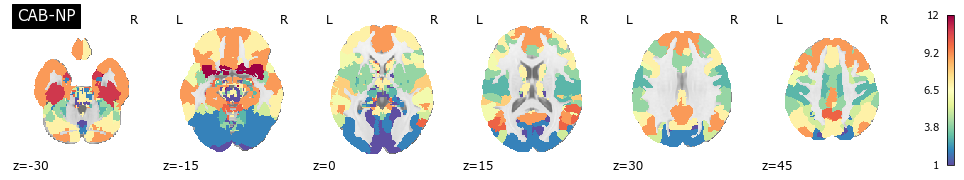

In [6]:
atlas_name = 'CAB-NP'
atlas_path = os.path.abspath(r'C:\Users\smine\OneDrive\Documents\GitHub\atlas\CAB-NP_volumetric\CAB-NP_volumetric_liberal.nii.gz')
atlas_masker = input_data.NiftiLabelsMasker(atlas_path, resampling_target="data", standardize=True,
                                            detrend=True, memory='nilearn_cache', memory_level=1)

### Load input data

In [7]:
msc_raw_path = os.path.abspath('D:\msc-raw')
msc_derivatives_path = os.path.abspath(r'D:\msc-derivatives\fmriprep')

# Lecture du format BIDS
layout = BIDSLayout(msc_raw_path, derivatives = msc_derivatives_path, validate = True,
                    database_path='pybids_True.sql', index_metadata=True, reset_database=False)

layout

BIDS Layout: ...D:\msc-raw | Subjects: 0 | Sessions: 0 | Runs: 0

### Input variables

In [8]:
subjects_id_list = layout.get_subjects()
print('Subjects ID:', subjects_id_list)

Subjects ID: ['MSC01', 'MSC02', 'MSC03', 'MSC04', 'MSC05', 'MSC06', 'MSC07', 'MSC08', 'MSC09', 'MSC10']
The repetition time is 2.2 secondes


### Parallele processing for time series calculation

In [13]:
time_series_info = pd.DataFrame(columns = subjects_id_list, index = ['path','nlevels','atlas'])
time_series_info.loc['atlas',:] = atlas_name

In [ ]:
directory = 'timeSeries_files'
if not os.path.exists(directory):
    os.makedirs(directory)

confounds_name = ['None', 'params9','aCompCor']

In [30]:
client = Client(threads_per_worker = 4, n_workers = 1)
client

C:\Users\smine\Anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63046 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:63049 Dashboard: http://127.0.0.1:63046/status,Cluster Workers: 1 Cores: 4 Memory: 8.44 GB


In [ ]:
results = []
for id in subjects_id_list:
    csv_path = os.path.join('timeSeries_files','id_atlas_timeSeries.csv'.replace('id',id).replace('atlas',atlas_name))

    sessions_sub = pb.get_sessions(layout, id)
    tasks_by_session_sub = pb.get_tasks(layout, id, sessions_sub)
    run_by_task_sub = pb.get_run(layout, id, sessions_sub, tasks_by_session_sub)
    subj_timeseries_df = pc.create_empty_df_timesseries(sessions_sub,tasks_by_session_sub, run_by_task_sub, confounds_name)

    # Calcul sur l'ensemble des nifti
    subjects_im_path = layout.get(subject = id, extension='nii.gz', suffix='bold', scope='derivatives',
                                  return_type='filename')

    params9 = Params9().load(subjects_im_path)
    aCompCor = AnatCompCor().load(subjects_im_path)


    time_series_info.loc['path',id] = csv_path
    time_series_info.loc['nlevels',id] = subj_timeseries_df.columns.nlevels
    subj_timeseries_df = dask.delayed(calculate_timeseries)(atlas_masker, run_by_task_sub, subjects_im_path, csv_path,
                                                            subj_timeseries_df, subject_confounds_list = [params9,aCompCor],
                                                            confounds_name= confounds_name)

    results.append(subj_timeseries_df)

In [23]:
info_csv_path = os.path.join('timeSeries_files','MSC_timeSeries_info.csv')
time_series_info.to_csv(info_csv_path, header= True)
time_series_info

,MSC01,MSC02,MSC03,MSC04,MSC05,MSC06,MSC07,MSC08,MSC09,MSC10
path,timeSeries_files\MSC01_CAB-NP_timeSeries.csv,timeSeries_files\MSC02_CAB-NP_timeSeries.csv,timeSeries_files\MSC03_CAB-NP_timeSeries.csv,timeSeries_files\MSC04_CAB-NP_timeSeries.csv,timeSeries_files\MSC05_CAB-NP_timeSeries.csv,timeSeries_files\MSC06_CAB-NP_timeSeries.csv,timeSeries_files\MSC07_CAB-NP_timeSeries.csv,timeSeries_files\MSC08_CAB-NP_timeSeries.csv,timeSeries_files\MSC09_CAB-NP_timeSeries.csv,timeSeries_files\MSC10_CAB-NP_timeSeries.csv
nlevels,3,3,3,3,3,3,3,3,3,3
tr,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
atlas,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP,CAB-NP


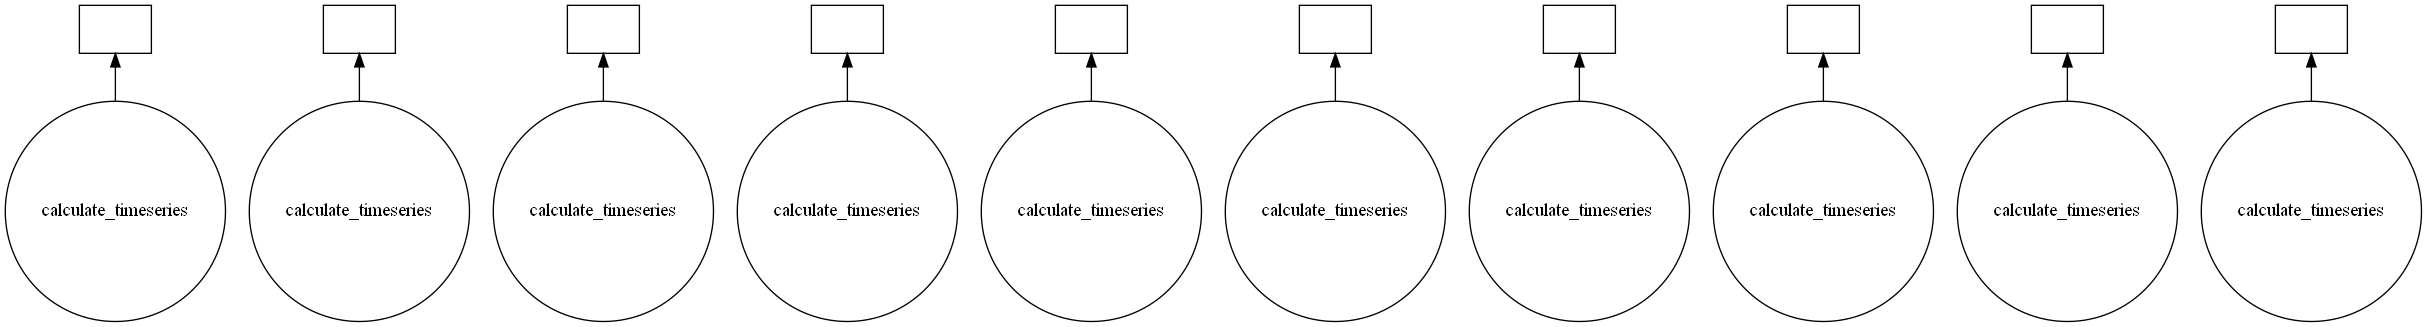

In [17]:
dask.visualize(results)
dask.compute(*results)
client.close()

### Subjects caracteristiques

In [8]:
time_series_info = pd.read_csv(info_csv_path, header = 0, index_col=0)
time_series_info

### Connectomes calculation

In [29]:
directory = 'connectivity_matrix'
if not os.path.exists(directory):
    os.makedirs(directory)

confounds_name = ['None', 'params9','aCompCor']
confounds_name.remove('None')

for confound in confounds_name:
    sub_dir = os.path.join(directory,confound)
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)

In [31]:
for id in time_series_info.columns:
    columns_level = ast.literal_eval(time_series_info.at['nlevels',id])
    time_series_subject = pd.read_csv(time_series_info.at['path', id], header = list(range(columns_level)), index_col = 0)
    time_series_subject = time_series_subject.applymap(lambda x: np.array(ast.literal_eval(x)))

    for caract in time_series_subject.columns:
        time_series_subject_caract = time_series_subject.loc[confounds_name,caract]
        correlation_measure = connectome.ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
        connectomes_matrix = correlation_measure.fit_transform(time_series_subject_caract)

        for i,confound in enumerate(confounds_name):
            connectome_folder_path = os.path.join(directory, confound)
            connectome_csv_path = os.path.join(connectome_folder_path, '_'.join((id,)+caract)+'.csv')
            np.savetxt(connectome_csv_path,connectomes_matrix[i], delimiter = ',')